In [1]:
import altair as alt
from pathlib import Path
import json
import pandas as pd
import numpy as np
import altair_viewer

alt.renderers.enable('altair_viewer', inline=True)

RendererRegistry.enable('altair_viewer')

# Process Data

In [2]:
results = {
    'no-static': ('../results/17_09_51-08_2020/data.csv', '../results/17_09_51-08_2020/sim.csv'),
    'static': ('../results/14_15_10-08_2020/data.csv', '../results/14_15_10-08_2020/sim2.csv'),
    'unrolled': ('../results/14_17_26-08_2020/data.csv', '../results/14_17_26-08_2020/sim.csv'),
    'fixed-static': ("../results/18_12_10-08_2020/data2.csv", "../results/14_15_10-08_2020/sim2.csv"),
    'fixed-no-static': ("../results/18_12_51-08_2020/data2.csv", "../results/17_09_51-08_2020/sim.csv"),
    'fixed-unrolled': ('../results/18_16_38-08_2020/data.csv', '../results/18_16_38-08_2020/sim.csv'),
}
data_lib = {}

for k, v in results.items():
    futil_hls_data = pd.read_csv(v[0])
    futil_latency = pd.read_csv(v[1])
    futil_hls_data = futil_hls_data[futil_hls_data['type'] != 'hls_total']
    for _, row in futil_latency.iterrows():
        bench_filt = futil_hls_data['benchmark'] == row[0]
        type_filt = futil_hls_data['type'] == 'futil'
        futil_hls_data.loc[(bench_filt) & (type_filt), 'latency'] = row[1]
    futil_hls_data = futil_hls_data.sort_values(by='benchmark').reset_index(drop=True)
    futil_hls_data['benchmark'] = futil_hls_data['benchmark'].apply(lambda x: x.split('-')[-1])
    data_lib[k] = futil_hls_data


# Timed Futil vs VHLS Graph

In [3]:
# Generate merged and normalized data for types of benchmarks
import math
merged = {}
KEYS = ['lut', 'latency']

for key in data_lib.keys():
    df = data_lib[key]
    hls = df[df['type'] == 'hls'][['benchmark'] + KEYS]
    futil = df[df['type'] == 'futil'][['benchmark'] + KEYS]
    # Merge the HLS and FuTIL data
    combined = hls.merge(futil, on='benchmark', suffixes = ['-hls', '-futil'])
    # Calculate normalized keys for KEYS
    for norm_key in KEYS:
        combined[f'{norm_key}-norm'] = np.log(combined[f'{norm_key}-futil'] / combined[f'{norm_key}-hls'])
        
    merged[key] = combined
    

In [4]:
df1 = merged['fixed-static']
df2 = merged['fixed-no-static']
df3 = merged['fixed-unrolled']
df1['type'] = 'Latency Sensitive'
df2['type'] = 'Latency Insensitive'
df3['type'] = 'Unrolled (Latency Sensitive)'
comp_data = df1.merge(df2, how='outer').merge(df3, how='outer')

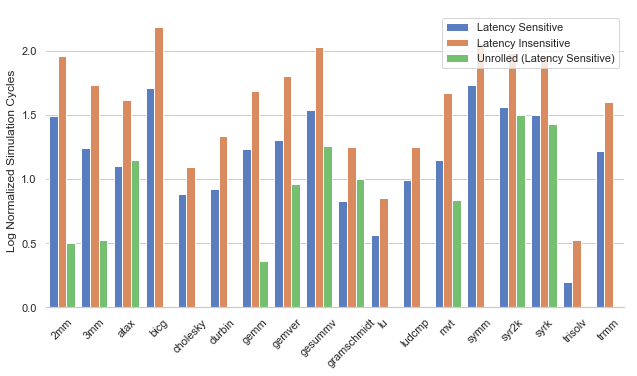

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

g = sns.catplot(
    x="benchmark", 
    y="latency-norm", 
    hue="type", 
    data=comp_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Log Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('log-norm-lat.pdf')

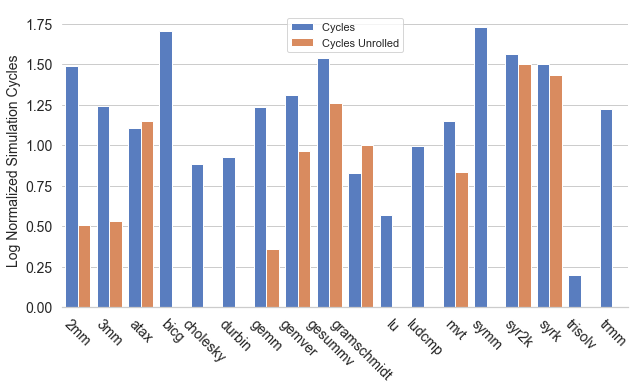

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
# unrolled_benches = data[data['type'] == 'Unrolled (Latency Sensitive)']['benchmark']
data = comp_data[comp_data['type'] != 'Latency Insensitive']
keep = ['benchmark', 'type', 'latency-norm']
data = data.drop(columns=data.columns.difference(keep))
data = data.melt(['benchmark', 'type'])
names = {'lut-norm': 'LUT', 'latency-norm': 'Cycles', 'Latency Sensitive': '', 'Unrolled (Latency Sensitive)': 'Unrolled'}
data['variable'] = data['variable'].apply(lambda x: names[x])
data['type'] = data['type'].apply(lambda x: names[x])
data['name'] = data['variable'] + ' ' + data['type']

g = sns.catplot(
    x="benchmark", 
    y="value", 
    hue="name", 
    data=data,
    kind="bar", 
    palette="muted",
    legend=False,
)

g.despine(left=True)
g.set_ylabels("Log Normalized Simulation Cycles", fontsize=14)
g.set_xlabels("")
g.set_yticklabels(fontsize=14)
g.set_xticklabels(rotation=-45, fontsize=14)
g.axes[0,0].legend(loc='upper center').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('unrolled-lat-sen-cycles.pdf')

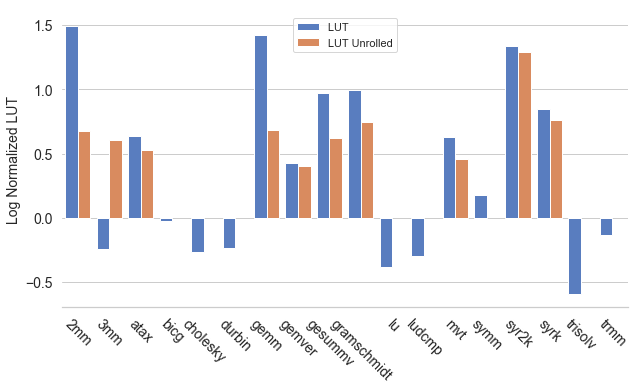

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
# unrolled_benches = data[data['type'] == 'Unrolled (Latency Sensitive)']['benchmark']
data = comp_data[comp_data['type'] != 'Latency Insensitive']
keep = ['benchmark', 'type', 'lut-norm']
data = data.drop(columns=data.columns.difference(keep))
data = data.melt(['benchmark', 'type'])
names = {'lut-norm': 'LUT', 'latency-norm': 'Cycles', 'Latency Sensitive': '', 'Unrolled (Latency Sensitive)': 'Unrolled'}
data['variable'] = data['variable'].apply(lambda x: names[x])
data['type'] = data['type'].apply(lambda x: names[x])
data['name'] = data['variable'] + ' ' + data['type']

g = sns.catplot(
    x="benchmark", 
    y="value", 
    hue="name", 
    data=data,
    kind="bar", 
    palette="muted",
    legend=False,
)

g.despine(left=True)
g.set_ylabels("Log Normalized LUT", fontsize=14)
g.set_xlabels("")
g.set_yticklabels(fontsize=14)
g.set_xticklabels(rotation=-45, fontsize=14)
g.axes[0,0].legend(loc='upper center').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('unrolled-lat-sen-lut.pdf')

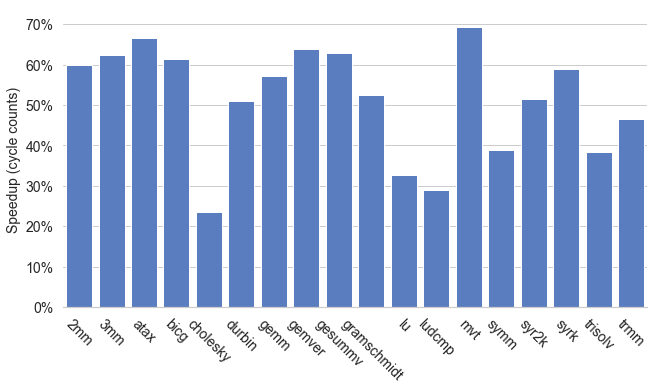

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

data = comp_data[comp_data["type"] != "Unrolled (Latency Sensitive)"]
keep = ['benchmark', 'type', 'latency-futil', 'lut-futil']
data = data.drop(columns=data.columns.difference(keep))
norm = data.loc[data['type'] == 'Latency Insensitive', 'latency-futil'].values / data.loc[data['type'] == 'Latency Sensitive', 'latency-futil'].values
norm = (norm - 1) * 100
# lut_norm = data.loc[data['type'] == 'Latency Sensitive', 'lut-futil'].values / data.loc[data['type'] == 'Latency Insensitive', 'lut-futil'].values

data = data[data['type'] == 'Latency Sensitive']
data['Latency Sensitive Cycles'] = norm

g = sns.catplot(
    x="benchmark", 
    y="value",
    hue="variable", 
    data=data.drop(columns=['type', 'latency-futil', 'lut-futil']).melt(['benchmark']),
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Speedup (cycle counts)", fontsize=14)
g.set_xlabels("")
g.set_yticklabels(fontsize=14)
g.set_xticklabels(rotation=-45, fontsize=14)
# g.axes[0,0].legend(loc='lower right').set_title('')
g.fig.set_size_inches(10,5)
# g.set(ylim=(1, 1.7))

import matplotlib as mpl
g.axes[0,0].yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

g.savefig('norm-lat-sen-insen.pdf', dpi=400)

# from scipy import stats
# stats.gmean((1 - data['Latency Sensitive LUTs'].values).clip(0.000001, 10))

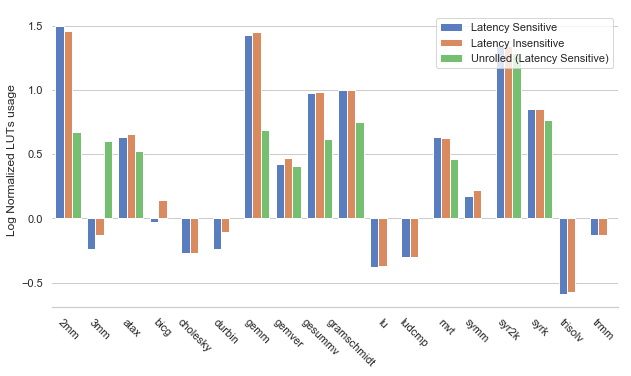

In [9]:
g = sns.catplot(
    x="benchmark", 
    y="lut-norm", 
    hue="type", 
    data=comp_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Log Normalized LUTs usage")
g.set_xlabels("")
g.set_xticklabels(rotation=-45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('log-norm-lut.pdf')

In [10]:


bars = alt.Chart().mark_bar().encode(
    x=alt.X('type', axis=alt.Axis(labels=False, title=None, ticks=False)),
    y=alt.Y('value',
            scale=alt.Scale(type='log'),
            axis=alt.Axis(title="VHLS / Calyx")),
    tooltip=['value', 'latency_mean', 'lut_mean'],
    color=alt.condition('datum.meet_timing == 0', alt.ColorValue('red'), 'type'),
)

vline = alt.Chart().mark_rule(color='black', size=0).encode(y='equal')
# meanLutLine = alt.Chart().mark_rule(color='blue').encode(y='lut_mean')
# meanLatLine = alt.Chart().mark_rule(color='green').encode(y='latency_mean')
height=300
alt.layer(bars, vline, data=data).facet(
    column=alt.Column('benchmark', header=alt.Header(labelOrient='bottom')),
    spacing=1,
).configure_title(
    orient='bottom'
).configure_view(
    continuousHeight=height
).configure_bar(
    y2=height/2
)
comp_data

,benchmark,lut-hls,latency-hls,lut-futil,latency-futil,lut-norm,latency-norm,type
0,2mm,939,3718,4183,16486,1.493968,1.489326,Latency Sensitive
1,3mm,742,5043,583,17513,-0.241162,1.244942,Latency Sensitive
2,atax,610,715,1150,2161,0.634058,1.106044,Latency Sensitive
3,bicg,327,218,318,1203,-0.027909,1.708079,Latency Sensitive
4,cholesky,802,1049,614,2542,-0.267114,0.885114,Latency Sensitive
5,durbin,1070,366,843,922,-0.238447,0.923912,Latency Sensitive
6,gemm,633,2684,2627,9213,1.423127,1.233307,Latency Sensitive
7,gemver,1338,1105,2044,4083,0.423733,1.306987,Latency Sensitive
8,gesummv,756,532,2001,2485,0.973361,1.541384,Latency Sensitive
9,gramschmidt,1662,8605,4511,19721,0.998497,0.829341,Latency Sensitive


# Futil
Static vs No-static

In [11]:
static = data_lib['static']
no_static = data_lib['no-static']
# df = pd.concat([static, no_static], keys=['static', 'no-static']).reset_index().drop(['level_1'], axis='columns').rename({'level_0': 'timing'}, axis='columns')
df = static[static['type'] == 'futil']
base = df.drop(columns=['source', 'meet_timing', 'dsp', 'type']).sort_values(by='benchmark').reset_index(drop=True)
other = no_static[no_static['type'] == 'futil'].sort_values(by='benchmark').reset_index(drop=True)
base['lut'] /= other['lut']
base['latency'] /= other['latency']
# base['dsp'] /= other['dsp']
data = base.melt(['benchmark'])
height=300
bars = alt.Chart().mark_bar().encode(
    x=alt.X('variable', axis=alt.Axis(labels=False, title=None, ticks=False)),
    y=alt.Y('value',
            scale=alt.Scale(type='log', base=2, domain=(2 ** -0.5, 2 ** 0.5)),
            axis=alt.Axis(title="Latency Sensitive / Latency Insensitive")),
    color=alt.Color('variable', scale=alt.Scale(scheme='tableau10'))
)

alt.layer(bars, data=data).facet(
    column=alt.Column(
        'benchmark',
        header=alt.Header(labelOrient='bottom', labelAngle=0, labelAnchor='middle', labelPadding=20),
    ),
    spacing=1
).configure_view(
    continuousHeight=height,
    strokeWidth=1,
    fill='white',
).configure_bar(
    y2=height/2
)


alt.FacetChart(...)

## Systolic array

In [20]:
systolic_data = pd.read_csv('../systolic-experiments/scan/data.csv')
systolic_lat = pd.read_csv('../systolic-experiments/scan/systolic.csv')
hls = pd.read_csv('../results/17_21_55-08_2020/data.csv')


hls = hls[hls['type'] == 'hls'].sort_values(by='benchmark').reset_index(drop=True).drop([1]).reset_index(drop=True)
# Only the "futil" rows have valid data
systolic_data = systolic_data[systolic_data['type'] == 'futil'].sort_values(by='benchmark').drop(columns=['meet_timing', 'source', 'type']).reset_index(drop=True)
# Remove systolic array data for which VHLS implementation failed
systolic_data = systolic_data.drop([0, 2, 4, 6]).reset_index(drop=True)

systolic_data['latency'] = systolic_lat['latency']
systolic_data['type'] = 'Calyx'
hls['type'] = 'HLS'
systolic_data = systolic_data.merge(hls[['benchmark', 'lut', 'latency', 'type', 'dsp']], how='outer')

# Better names
systolic_data['benchmark'] = systolic_data['benchmark'].apply(lambda x: "{} x {}".format(x.split('_')[1], x.split('_')[1]))


systolic_data

,benchmark,lut,dsp,latency,type
0,2 x 2,528.0,12.0,26,Calyx
1,4 x 4,2219.0,48.0,77,Calyx
2,6 x 6,7851.0,108.0,132,Calyx
3,8 x 8,14827.0,192.0,191,Calyx
4,2 x 2,808.0,12.0,62,HLS
5,4 x 4,2387.0,48.0,322,HLS
6,6 x 6,4909.0,108.0,926,HLS
7,8 x 8,8443.0,192.0,2210,HLS


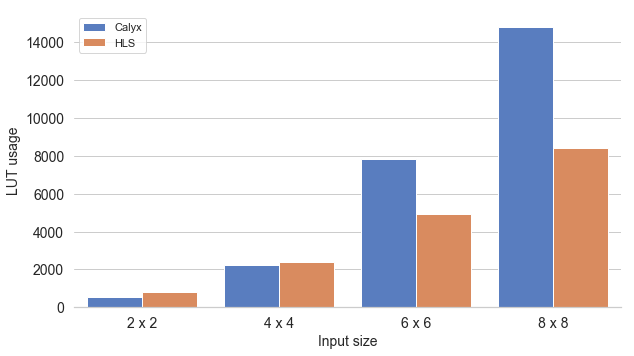

In [21]:
g = sns.catplot(
    x="benchmark", 
    y="lut", 
    hue="type", 
    data=systolic_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("LUT usage", fontsize=14)
g.set_xlabels("Input size", fontsize=14)
g.set_yticklabels(fontsize=14)
g.set_xticklabels(fontsize=14)
g.axes[0,0].legend(loc='upper left').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('systolic-lut.pdf')

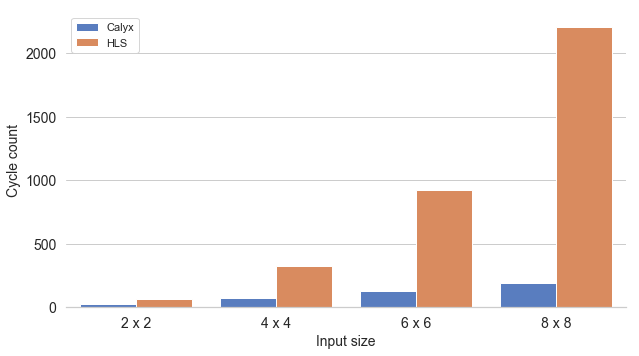

In [22]:
g = sns.catplot(
    x="benchmark", 
    y="latency", 
    hue="type", 
    data=systolic_data,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Cycle count", fontsize=14)
g.set_xlabels("Input size", fontsize=14)
g.set_yticklabels(fontsize=14)
g.set_xticklabels(fontsize=14)
g.axes[0,0].legend(loc='upper left').set_title('')
g.fig.set_size_inches(10,5)
g.savefig('systolic-lat.pdf')

In [23]:

# systolic_data['hls_dsp'] = hls['dsp']
# systolic_data['hls_lut'] = hls['lut']
systolic_data['lut / 10'] = systolic_data['lut'] / 10
# systolic_data['lat_expect'] = [26 * (x + (np.sqrt(x))) for x in range(1,9)]
d = systolic_data.melt(['benchmark'])
alt.Chart(d).mark_bar().encode(
    x=alt.X('variable', axis=alt.Axis(labels=False, ticks=False,title=None)),
    y='value',
    color='variable',
    column=alt.Column(
        'benchmark', 
        header=alt.Header(labelOrient='bottom', labelAngle=0, labelAnchor='middle', labelPadding=20),
        spacing=1
    ),
    tooltip=['value']
).transform_filter(
    'datum.variable != "lut" & datum.variable != "dsp"'
).configure_view(
    continuousHeight=200
)

alt.Chart(...)

In [ ]:
systolic_data = pd.read_csv('../systolic-experiments/scan/data.csv')
systolic_data

In [ ]:
data_lib['static']